# Scraping Top Repositories For Topics On GitHub


- **Introduction about web scraping**


Web scraping is an automatic method to obtain large amounts of data from websites. Most of this data is unstructured data in an HTML format which is then converted into structured data in a spreadsheet or a database so that it can be used in various applications. There are many different ways to perform web scraping to obtain data from websites. These include using online services, particular API’s or even creating your code for web scraping from scratch. Many large websites, like Google, Twitter, Facebook, StackOverflow, etc. have API’s that allow you to access their data in a structured format. This is the best option, but there are other sites that don’t allow users to access large amounts of data in a structured form or they are simply not that technologically advanced. In that situation, it’s best to use Web Scraping to scrape the website for data.


- **Introduction about GitHub amd GitHub Repositories**

GitHub is a Git repository hosting service. GitHub also facilitates with many of its features, such as access control and collaboration. It provides a Web-based graphical interface.

It is a web-based version-control and collaboration platform for software developers. 

Git is used to store the source code for a project and track the complete history of all changes to that code. It allows developers to collaborate on a project more effectively by providing tools for managing possibly conflicting changes from multiple developers. GitHub allows developers to change, adapt and improve software from its public repositories for free, but it charges for private repositories, offering various paid plans. Each public or private repository contains all of a project's files, as well as each file's revision history. Repositories can have multiple collaborators and can be either public or private. 


- GitHub Repository

A GitHub repository can be used to store a development project.

It can contain folders and any type of files (HTML, CSS, JavaScript, Documents, Data, Images).

A GitHub repository should also include a licence file and a README file about the project.

A GitHub repository can also be used to store ideas, or any resources that you want to share.



-  **Tools Used**

 (Python, requests, Beautiful Soup, Pandas)



**Here are the steps we'll follow:**

- We're going to scrape https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we'll get the top 25 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:

```
Repo Name,Username,Stars,Repo URL
three.js,mrdoob,69700,https://github.com/mrdoob/three.js
libgdx,libgdx,18300,https://github.com/libgdx/libgdx
```

# Scrape the list of topics from Github

Explain how you'll do it.

- use requests to downlaod the page
- user BS4 to parse and extract information
- convert to a Pandas dataframe

Let's write a function to download the page.

In [26]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

def get_topics_page():
    # TODO - add comments
    topics_url = 'https://github.com/topics'
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    doc = BeautifulSoup(response.text, 'html.parser')
    return doc

In [2]:
doc = get_topics_page()

In [3]:
type(doc)

bs4.BeautifulSoup

In [4]:
doc.find('a')

<a class="px-2 py-4 color-bg-accent-emphasis color-fg-on-emphasis show-on-focus js-skip-to-content" href="#start-of-content">Skip to content</a>

Let's create some helper functions to parse information from the page.

To get topic titles, we can pick `p` tags with the `class` ...

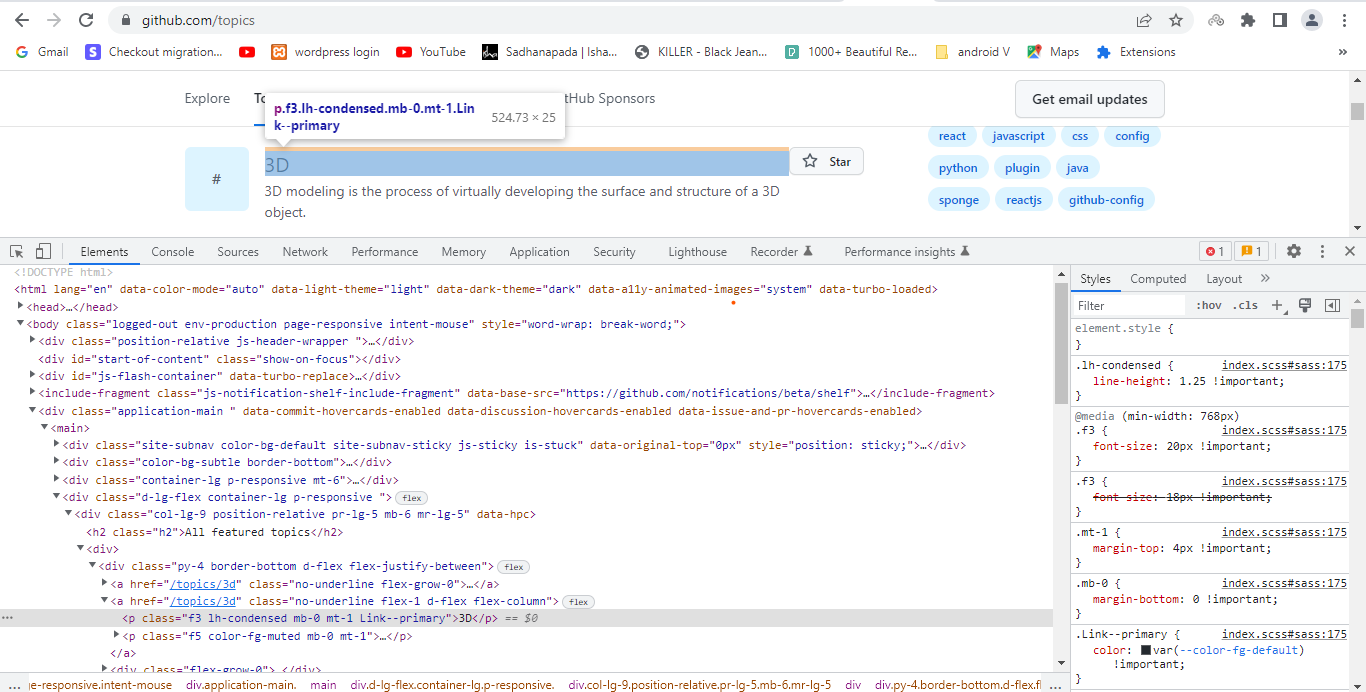

In [8]:
def get_topic_titles(doc):
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'   
    topic_title_tags = doc.find_all('p', {'class': selection_class})      # topic titles
    topic_titles = []
    for tag in topic_title_tags:      # creating a list of topic titles
        topic_titles.append(tag.text)
    return topic_titles

`get_topic_titles` can be used to get the list of titles

In [9]:
titles = get_topic_titles(doc)

In [10]:
titles

['3D',
 'Ajax',
 'Algorithm',
 'Amp',
 'Android',
 'Angular',
 'Ansible',
 'API',
 'Arduino',
 'ASP.NET',
 'Atom',
 'Awesome Lists',
 'Amazon Web Services',
 'Azure',
 'Babel',
 'Bash',
 'Bitcoin',
 'Bootstrap',
 'Bot',
 'C',
 'Chrome',
 'Chrome extension',
 'Command line interface',
 'Clojure',
 'Code quality',
 'Code review',
 'Compiler',
 'Continuous integration',
 'COVID-19',
 'C++']

In [11]:
len(titles)

30

In [12]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

Similarly we have defined functions for description and URLs.

In [6]:
def get_topic_descs(doc):
    desc_selector = 'f5 color-fg-muted mb-0 mt-1'
    topic_desc_tags = doc.find_all('p', {'class': desc_selector})    # topic description 
    topic_descs = []
    for tag in topic_desc_tags:
        topic_descs.append(tag.text.strip())
    return topic_descs

In [7]:
def get_topic_urls(doc):
    topic_link_tags = doc.find_all('a', {'class': 'no-underline flex-grow-0'})      # topic link urls from topic page
    topic_urls = []
    base_url = 'https://github.com'
    for tag in topic_link_tags:
        topic_urls.append(base_url + tag['href'])
    return topic_urls

Let's put this all together into a single function

In [13]:
def scrape_topics():
    topics_url = 'https://github.com/topics'
    response = requests.get(topics_url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    topics_dict = {
        'title': get_topic_titles(doc),
        'description': get_topic_descs(doc),
        'url': get_topic_urls(doc)
    }
    return pd.DataFrame(topics_dict)

## Get the top 20 repositories from a topic page

In [14]:
def get_topic_page(topic_url):   # function to scrape all the topic imformation
    # Download the page
    response = requests.get(topic_url)
    # Check successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    # Parse using Beautiful soup
    topic_doc = BeautifulSoup(response.text, 'html.parser')
    return topic_doc

In [15]:
doc = get_topic_page('https://github.com/topics/3d')

In [19]:
def parse_star_count(stars):
    stars=stars.strip()
    if stars[-1]=='k':
        return int(float(stars[:-1])*1000)
    return(int(stars))

In [20]:
def get_repo_info(h3_tag, star_tag):
    # returns all the required info about a repository
    a_tags = h3_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url =  base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag.text.strip())
    return username, repo_name, stars, repo_url

In [21]:
def get_topic_repos(topic_doc):
    
    # Get the h3 tags containing repo title, repo URL and username
    h3_selection_class = 'f3 color-fg-muted text-normal lh-condensed'
    repo_tags = topic_doc.find_all('h3', {'class' : h3_selection_class } )
    
    # Get star tags
    star_tags = topic_doc.find_all('span', {'class': 'Counter js-social-count'})  
    
    # create a dictinary
    topic_repos_dict = { 'username': [], 'repo_name': [], 'stars': [],'repo_url': []}

    # Get repo info
    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
        
    return pd.DataFrame(topic_repos_dict)

In [22]:
def scrape_topic(topic_url, path):
    if os.path.exists(path):
        print("The file {} already exists. Skipping...".format(path))
        return
    topic_df = get_topic_repos(get_topic_page(topic_url))
    topic_df.to_csv(path, index=None)

## Putting it all together

- We have a funciton to get the list of topics
- We have a function to create a CSV file for scraped repos from a topics page
- Let's create a function to put them together

In [23]:
def scrape_topics_repos():
    print('Scraping list of topics')
    topics_df = scrape_topics()
    
    os.makedirs('data', exist_ok=True)
    for index, row in topics_df.iterrows():
        print('Scraping top repositories for "{}"'.format(row['title']))
        scrape_topic(row['url'], 'data/{}.csv'.format(row['title']))

Let's run it to scrape the top repos for the all the topics on the first page of https://github.com/topics

In [ ]:
scrape_topics_repos()

We can check that the CSVs were created properly

#### read and display a CSV using Pandas EXAMPLE:
pd.read_csv('data/Android.csv')
